In [1]:
import sys
import shutil
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import flopy

flopy is installed in /Users/langevin/langevin/dev/flopy3fork.git/flopy


In [2]:
# Path to the MODFLOW 6 repository
mf6path = '../../../modflow6-fork.git'
assert os.path.isdir(mf6path)

In [3]:
mf6exe = os.path.join(mf6path, 'bin', 'mf6')
mf6exe = os.path.abspath(mf6exe)
assert os.path.isfile(mf6exe)
print(mf6exe)

/Users/langevin/langevin/dev/modflow6-fork.git/bin/mf6


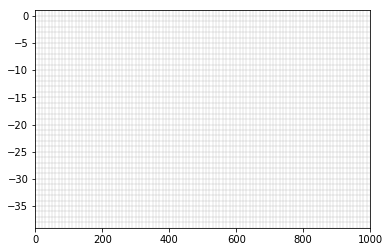

In [4]:
def make_grid(nlay, nrow, ncol, lx, top0, bottom):
    top = np.zeros((nrow, ncol), dtype=np.float)
    botm = np.zeros((nlay, nrow, ncol), dtype=np.float)

    delr = lx / ncol
    delc = 1.
    delv = (top0 - bottom) / nlay
    top[:, :] = top0
    
    for k in range(nlay):
        tp = top0
        if k > 0:
            tp = botm[k - 1, 0, 0]
        botm[k, :, :] = tp - delv
    
    delr = np.ones((ncol)) * delr
    delc = np.ones((nrow)) * delc
    return (delr, delc, top, botm)

nlay = 40
nrow = 1
ncol = 100
lx = 1000.
top0 = 1.
bottom = -39.
delr, delc, top, botm = make_grid(nlay, nrow, ncol, lx, top0, bottom)
mg = flopy.discretization.StructuredGrid(nlay=nlay, nrow=nrow, ncol=ncol,
                                         delr=delr, delc=delc, top=top, botm=botm)
pxs = flopy.plot.PlotCrossSection(modelgrid=mg, line={'row': 0})
pxs.plot_grid(alpha=1., lw=0.1)


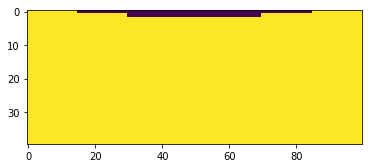

In [5]:
def lakeidomain(nrow, ncol, lx, top0, bottom, lakebot):
    import flopy.discretization as fgrid
    from shapely.geometry import Polygon
    from flopy.utils.gridintersect import GridIntersect
    ilak = np.ones((nrow, ncol), dtype=np.int)
    delr = lx / ncol * np.ones(ncol)
    delc = (top0 - bottom) / nrow * np.ones(nrow)
    xoff = 0.
    yoff = bottom
    sgr = fgrid.StructuredGrid(delc, delr, top=None, botm=None, xoff=xoff, yoff=yoff)
    poly = [(150, top0), (850, top0), (550, lakebot), (450, lakebot), (150, top0)]
    p = Polygon(shell=poly)
    ix = GridIntersect(sgr)
    result = ix.intersect_polygon(p)
    for i, j in result['cellids']:
        ilak[i, j] = 0
    return ilak
    
#lakeidomain = lakeidomain(nlay, ncol, 1000, top0, bottom, -1)
idomain = lakeidomain(nlay, ncol, lx, top0, bottom, -1)
plt.imshow(idomain)
#pmv = flopy.plot.PlotMapView(modelgrid=sgr)
#pmv.plot_grid()

In [6]:
def calcdens(c, rho0=1000., drhodc=0.7):
    return rho0 + drhodc * c

def get_sealevel(t, sl_start, slr_rate):
    return sl_start + slr_rate * t

def get_top(x, top0, slopels):
    return top0 + x * slopels

In [39]:
def get_model(ws, name, nlay, nrow, ncol, lx, top0, bottom,
              time_end,
              hk, vk, specific_storage, porosity, 
              rechgarge,
              alpha_l, alpha_t,
              cfresh, csalt,
              hlak=0., clak=0.,
              sl_start=0., slr_rate=0.,
              nper=100,
              hstrt=None, cstrt=None,
              lakeon=True,
              converge_continue=False,
              verbosity_level=1):

    delr, delc, top, botm = make_grid(nlay, nrow, ncol, lx, top0, bottom)

    nstp = 1
    perlen = nper * [time_end / nper]
    tdis_rc = []
    for i in range(nper):
        tdis_rc.append((perlen[i], nstp, 1.0))

    nouter, ninner = 100, 300
    hclose, rclose, relax = 1e-7, 1e-5, 0.97

    # build MODFLOW 6 files
    sim = flopy.mf6.MFSimulation(sim_name=name, version='mf6',
                                 exe_name=mf6exe,
                                 verbosity_level=verbosity_level,
                                 sim_ws=ws)
    if converge_continue:
        sim.name_file.continue_ = True
    # create tdis package
    tdis = flopy.mf6.ModflowTdis(sim, time_units='DAYS',
                                 nper=nper, perioddata=tdis_rc)

    # create gwf model
    gwfname = 'gwf_' + name
    gwtname = 'gwt_' + name
    
    gwf = flopy.mf6.ModflowGwf(sim, modelname=gwfname, newtonoptions=True)
    imsgwf = flopy.mf6.ModflowIms(sim, print_option='ALL',
                                  outer_hclose=hclose,
                                  outer_maximum=nouter,
                                  under_relaxation='DBD',
                                  inner_maximum=ninner,
                                  inner_hclose=hclose, rcloserecord=rclose,
                                  linear_acceleration='BICGSTAB',
                                  scaling_method='NONE',
                                  reordering_method='NONE',
                                  relaxation_factor=relax,
                                  no_ptcrecord=True,
                                  filename='{}.ims'.format(gwfname))
    single_matrix = False
    if single_matrix:
        sim.register_ims_package(imsgwf, [gwfname, gwtname])
    else:
        sim.register_ims_package(imsgwf, [gwfname])

    idomain = None
    if lakeon:
        lakebot = -1
        idomain = lakeidomain(nlay, ncol, lx, top0, bottom, lakebot)
        idomain = idomain.reshape((nlay, nrow, ncol))
    dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                                  delr=delr, delc=delc,
                                  top=top, botm=botm, idomain=idomain)

    # initial conditions
    if hstrt is None:
        hstrt = top0
    else:
        hstrt = {'filename': 'hstrt.bin', 'factor': 1.0, 
                 'data': hstrt, 'binary': 'True'}
    ic = flopy.mf6.ModflowGwfic(gwf, strt=hstrt)

    # node property flow
    npf = flopy.mf6.ModflowGwfnpf(gwf, xt3doptions=False,
                                  save_flows=True,
                                  save_specific_discharge=True,
                                  icelltype=1,
                                  k=hk, k33=vk)
    
    sto = flopy.mf6.ModflowGwfsto(gwf, iconvert=1, sy=porosity, ss=specific_storage)

    hhformulation = True
    hhoptions = False
    if hhformulation:
        hhoptions = [('HHFORMULATION'), ]
        hhoptions.append(('LHS'))
    buy = flopy.mf6.ModflowGwfbuy(gwf, hhoptions=hhoptions)
    

    xc, yc, zc = gwf.modelgrid.xyzcellcenters
    botm = gwf.modelgrid.botm
    delt = time_end / nper
    delv = (top0 - bottom) / nlay
    ghbdict = {}
    for iper, t in enumerate(np.arange(delt, time_end + delt, delt)):
        sl = get_sealevel(t, sl_start, slr_rate)
        ghblist = []
        cond = hk * delc[0] * delv / (0.5 * delr[0])
        for k in range(nlay):
            ghbl = [(k, 0, 0), sl, cond, csalt, calcdens(csalt), zc[k, 0, 0]]
            ghbr = [(k, 0, ncol - 1), sl, cond, csalt, calcdens(csalt), zc[k, 0, ncol - 1]]
            if sl > botm[k, 0, 0]:
                ghblist.append(ghbl)
                ghblist.append(ghbr)
        ghbdict[iper] = ghblist
    
    #ghblak = [(0, 0, int(ncol / 2)), 0., cond*100, cfresh, calcdens(cfresh), zc[0, 0, 0]]
    #ghblist.append(ghblak)

    if len(ghbdict) > 0:
        ghb = flopy.mf6.ModflowGwfghb(gwf,
                                      stress_period_data=ghbdict,
                                      print_input=True,
                                      print_flows=True,
                                      save_flows=False,
                                      auxiliary=['CONCENTRATION', 'DENSITY', 'ELEVATION'],
                                      pname='GHB-0')
    
    rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=recharge)
    
    if lakeon:
        ilakeabove = np.zeros((nlay, nrow, ncol), dtype=np.int)
        for k in range(nlay):
            for j in range(ncol):
                if idomain[k, 0, j] == 0:
                    ilakeabove[k + 1, 0, j] = 1
                    ilakeabove[k, 0, j] = 0
        klak, ilak, jlak = np.where(ilakeabove == 1)
        nlakconn = klak.shape[0]
        pak_data = [(0, hlak, nlakconn, 0.)]
        bedleak = 0.1 * vk / (0.5 * delv)
        con_data = []
        for iconn, (k, i, j) in enumerate(zip(klak, ilak, jlak)):
            con_data.append([0, iconn, (k, i, j), 'VERTICAL', bedleak, 10., 10., 1, 1])
        p_data = [(0, 'EVAPORATION', 0.5 * recharge), (0, 'RAINFALL', recharge)]
        lak = flopy.mf6.ModflowGwflak(gwf, nlakes=1, stage_filerecord='stage',
                                      print_stage=True, print_flows=True,
                                      packagedata=pak_data,
                                      connectiondata=con_data,
                                      lakeperioddata=p_data,
                                      pname='LAK0',
                                      auxiliary='CONCENTRATION')
    
    # output control
    saverecord = {0: [('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                  1: [('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                  nper - 1: [('HEAD', 'ALL'), ('BUDGET', 'ALL')]}
    printrecord = {0: [('HEAD', 'ALL'), ('BUDGET', 'LAST')],
                  1: None,
                  nper - 1: [('HEAD', 'ALL'), ('BUDGET', 'LAST')]}
    oc = flopy.mf6.ModflowGwfoc(gwf,
                                budget_filerecord='{}.cbc'.format(gwfname),
                                head_filerecord='{}.hds'.format(gwfname),
                                headprintrecord=[
                                    ('COLUMNS', 10, 'WIDTH', 15,
                                     'DIGITS', 6, 'GENERAL')],
                                saverecord=saverecord,
                                printrecord=printrecord)

    # create gwt model
    gwt = flopy.mf6.MFModel(sim, model_type='gwt6', modelname=gwtname,
                            model_nam_file='{}.nam'.format(gwtname))

    if not single_matrix:
        imsgwt = flopy.mf6.ModflowIms(sim, print_option='ALL',
                                      outer_hclose=hclose,
                                      outer_maximum=nouter,
                                      under_relaxation='NONE',
                                      inner_maximum=ninner,
                                      inner_hclose=hclose, rcloserecord=rclose,
                                      linear_acceleration='BICGSTAB',
                                      scaling_method='NONE',
                                      reordering_method='NONE',
                                      relaxation_factor=relax,
                                      filename='{}.ims'.format(gwtname))
        sim.register_ims_package(imsgwt, [gwt.name])

    dis = flopy.mf6.ModflowGwtdis(gwt, nlay=nlay, nrow=nrow, ncol=ncol,
                                  delr=delr, delc=delc,
                                  top=top, botm=botm, idomain=idomain)

    # initial conditions
    if cstrt is None:
        cstrt = csalt
    else:
        cstrt = {'filename': 'cstrt.bin', 'factor': 1.0, 
                 'data': cstrt, 'binary': 'True'}
    ic = flopy.mf6.ModflowGwtic(gwt, strt=cstrt)

    # advection
    adv = flopy.mf6.ModflowGwtadv(gwt, scheme='UPSTREAM')

    # dispersion
    #dsp = flopy.mf6.ModflowGwtdsp(gwt, xt3d=False, diffc=0.,
    #                              alh=alpha_l, ath1=alpha_t)

    # mass storage and transfer
    porosity = porosity
    mst = flopy.mf6.ModflowGwtmst(gwt, porosity=porosity)
    
    # sources
    sourcerecarray = [('GHB-0', 'AUX', 'CONCENTRATION')]
    ssm = flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray,
                                  filename='{}.ssm'.format(gwtname))
    
    if lakeon:
        packagedata = [(0, clak)]
        lakeperioddata = [(0, 'RAINFALL', 0.)]
        lkt = flopy.mf6.ModflowGwtlkt(gwt, print_concentration=True,
                                      concentration_filerecord='lakconc.bin',
                                      packagedata=packagedata, 
                                      lakeperioddata=lakeperioddata,
                                      pname='LAK0')

    # output control
    saverecord = {0: [('CONCENTRATION', 'ALL'), ('BUDGET', 'LAST')],
                  1: [('CONCENTRATION', 'ALL')],
                  nper - 1: [('CONCENTRATION', 'ALL'), ('BUDGET', 'LAST')]}
    printrecord = {0: [('CONCENTRATION', 'ALL'), ('BUDGET', 'LAST')],
                  1: None,
                  nper - 1: [('CONCENTRATION', 'ALL'), ('BUDGET', 'LAST')]}
    oc = flopy.mf6.ModflowGwtoc(gwt,
                                budget_filerecord='{}.cbc'.format(gwtname),
                                concentration_filerecord='{}.ucn'.format(
                                    gwtname),
                                concentrationprintrecord=[
                                    ('COLUMNS', 10, 'WIDTH', 15,
                                     'DIGITS', 6, 'GENERAL')],
                                saverecord=saverecord,
                                printrecord=printrecord)

    # GWF GWT exchange
    gwfgwt = flopy.mf6.ModflowGwfgwt(sim, exgtype='GWF6-GWT6',
                                     exgmnamea=gwfname, exgmnameb=gwtname,
                                     filename='{}.gwfgwt'.format(name))

    return sim

In [8]:
def get_results(ws, sim):
    modelnames = list(sim.model_names)
    gwfname = modelnames[0]
    gwtname = modelnames[1]
    gwf = sim.get_model(gwfname)
    gwt = sim.get_model(gwtname)

    fname = os.path.join(ws, gwfname + '.hds')
    hdobj = flopy.utils.HeadFile(fname, precision='double')
    head = hdobj.get_alldata()

    fname = os.path.join(ws, gwtname + '.ucn')
    cnobj = flopy.utils.HeadFile(fname, precision='double', text='CONCENTRATION')
    conc = cnobj.get_alldata()
    times = cnobj.get_times()
    
    fname = os.path.join(ws, gwfname + '.cbc')
    budobj = flopy.utils.CellBudgetFile(fname, precision='double')
    spdis = budobj.get_data(text='DATA-SPDIS')
    
    fname = os.path.join(ws, 'stage')
    stobj = flopy.utils.HeadFile(fname, precision='double', text='STAGE')
    lakstage = stobj.get_alldata()

    fname = os.path.join(ws, 'lakconc.bin')
    lkcobj = flopy.utils.HeadFile(fname, precision='double', text='CONCENTRATION')
    lakconc = lkcobj.get_alldata()

    
    return head, conc, spdis, lakstage, lakconc, times

In [9]:
def get_colored_patch_collection(modelgrid, head=None, ec='k', fc='k', zorder=None):
    # create patches for each cell
    xv, yv, zv = modelgrid.xyzvertices
    patches = []
    for k in range(modelgrid.nlay):
        for j in range(modelgrid.ncol):
            x0 = xv[0, j]
            x1 = xv[0, j + 1]
            y0 = zv[k, 0, j]
            y1 = zv[k + 1, 0, j]
            if head is not None:
                y0 = min(y0, head[k, 0, j])
                y0 = max(y0, modelgrid.botm[k, 0, j])
            poly = [[x0, y0], [x1, y0], [x1, y1], [x0, y1], [x0, y0]]
            #print(poly)
            patch = matplotlib.patches.Polygon(poly, closed=True, edgecolor=ec, facecolor=fc)
            patches.append(patch)
    pc = matplotlib.collections.PatchCollection(patches, zorder=zorder, match_original=True, cmap='jet')
    return pc

In [88]:
def make_figure(gwf, head, conc, spdis, t, top0, csalt=35., 
                ax2dict=None, asoln=None, streamplot=False, vectors=False,
                figname=None):

    plt.rcParams['savefig.facecolor'] = '1.0'
    
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 5)
    #ax.set_aspect('equal')
    
    pxs = flopy.plot.PlotCrossSection(model=gwf, line={'row': 0}, ax=ax)
    pxs.plot_grid(alpha=1., lw=0.1)

    # draw a patch collection, with the water table as the top of the cell
    pc = get_colored_patch_collection(gwf.modelgrid, head, ec='none', fc='none', zorder=2)
    pc.set_array(conc.flatten())
    ax.add_collection(pc)

    cbar = plt.colorbar(pc, shrink=0.5)
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('CONCENTRATION, IN GRAMS PER LITER', rotation=90)
    
    # 50% seawater line
    atoplot = np.ma.masked_where(head < gwf.dis.botm.array, conc)
    pxs.contour_array(atoplot, levels=np.array([1, csalt/2.]), 
                      linestyles = ['--','-'], colors=['k', 'k'])

    if vectors:
        pxs.plot_specific_discharge(spdis, head=head, color='white',
                                    kstep=1, hstep=1, pivot='mid', minlength=0.5,
                                    scale=0.1, width=0.001, headwidth=3., headlength=5.0, 
                                    headaxislength=4.5, minshaft=0.01,
                                    zorder=10, alpha=0.50)
    
    if streamplot:
        x = gwf.modelgrid.xcellcenters
        y = gwf.modelgrid.zcellcenters
        X, Y = np.meshgrid(x, y[:, 0, 0])
        u = spdis['qx']
        u = u.reshape(X.shape)
        v = spdis['qz']
        v = v.reshape(X.shape)
        sc = ax.streamplot(X, Y, u, v, color='yellow', linewidth=0.1, arrowsize=0.35)

    # head surface
    #ax.plot(gwf.modelgrid.xcellcenters[0], head[kper, 0, 0, :])
    #plt.colorbar(qm, shrink=0.5)
    ax.set_title('TIME = {:.2f} years'.format(t / 365.))
    ax.set_xlabel('DISTANCE, IN METERS')
    ax.set_ylabel('ELEVATION, IN METERS')
    
    plt.tight_layout()
    
    if ax2dict is not None:
        with plt.rc_context({'axes.edgecolor':'white', 
                             'axes.facecolor':'yellow',
                             'xtick.color':'white', 
                             'ytick.color':'white', 
                             'font.size': 8,
                             'axes.labelcolor': 'white',
                             }):
            if 'limits' in ax2dict:
                limits = ax2dict['limits']
            else:
                limits = [0.15, 0.22, 0.2, 0.2]
            xdata = ax2dict['xdata']
            ydata = ax2dict['ydata']
            ax2 = fig.add_axes(limits)
            ax2.plot(xdata, ydata, 'k-')
            if 'xlim' in ax2dict:
                ax2.set_xlim(*ax2dict['xlim'])
            if 'ylim' in ax2dict:
                ax2.set_ylim(*ax2dict['ylim'])
            if 'xlabel' in ax2dict:
                ax2.set_xlabel(ax2dict['xlabel'])
            if 'ylabel' in ax2dict:
                ax2.set_ylabel(ax2dict['ylabel'])
    
    if figname is not None:
        plt.savefig(figname, dpi=300)
        plt.close(fig)
        
    return ax

In [11]:
def make_movie(figfile, anmfile):
    from subprocess import check_output
    vcodec = 'libx264'
    if os.path.isfile(anmfile):
        os.remove(anmfile)
    output = check_output(['ffmpeg',
                           '-f', 'image2',
                           '-i', figfile,
                           '-vb', '20M',
                           '-vcodec', vcodec,
                           '-pix_fmt', 'yuv420p',
                           anmfile])    

In [12]:
# Protection
sim = None
sim0 = None
gwf = None
ws = None
ws0 = None
head = None
head0 = None
conc = None
conc0 = None

# Model Run (No SLR)

In [13]:
nlay = 20
nrow = 1
ncol = 40
lx = 1000.
top0 = 2.
bottom = -50.
nper = 3000
time_end = 365 * 1000.
cfresh = 0.
csalt = 35.
recharge = 0.0005 
porosity = 0.35
hk = 10. # m/day
vk = 10.
specific_storage = 0.008 # per meter
alpha_l = 0. # meter
alpha_t = 0.0 # meter
cstrt = csalt

In [14]:
ws0 = 'temp/pxx_gwt_lakslr'
name = 'lakslr'
sim0 = get_model(ws0, name, nlay, nrow, ncol, lx,
                 top0, bottom, 
                 time_end, 
                 hk, vk, specific_storage, porosity, 
                 recharge,
                 alpha_l, alpha_t,
                 cfresh, csalt, nper=nper, cstrt=cstrt,
                 verbosity_level=1,
                 converge_continue=True)
sim0.write_simulation()
v = sim0.run_simulation(report=True)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing ims package ims_0...
  writing package lakslr.gwfgwt...
  writing model gwf_lakslr...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package buy...
    writing package ghb-0...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 40 based on size of stress_period_data
    writing package rcha...
    writing package lak0...
    writing package oc...
  writing model gwt_lakslr...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package adv...
    writing package mst...
    writing package ssm...
    writing package lak0...
    writing package oc...
FloPy is using the following  executable to run the model: /Users/langevin/langevin/dev/modflow6-fork.git/bin/mf6
                                   

 Solving:  Stress period:   121    Time step:     1
 Solving:  Stress period:   122    Time step:     1
 Solving:  Stress period:   123    Time step:     1
 Solving:  Stress period:   124    Time step:     1
 Solving:  Stress period:   125    Time step:     1
 Solving:  Stress period:   126    Time step:     1
 Solving:  Stress period:   127    Time step:     1
 Solving:  Stress period:   128    Time step:     1
 Solving:  Stress period:   129    Time step:     1
 Solving:  Stress period:   130    Time step:     1
 Solving:  Stress period:   131    Time step:     1
 Solving:  Stress period:   132    Time step:     1
 Solving:  Stress period:   133    Time step:     1
 Solving:  Stress period:   134    Time step:     1
 Solving:  Stress period:   135    Time step:     1
 Solving:  Stress period:   136    Time step:     1
 Solving:  Stress period:   137    Time step:     1
 Solving:  Stress period:   138    Time step:     1
 Solving:  Stress period:   139    Time step:     1
 Solving:  S

 Solving:  Stress period:   281    Time step:     1
 Solving:  Stress period:   282    Time step:     1
 Solving:  Stress period:   283    Time step:     1
 Solving:  Stress period:   284    Time step:     1
 Solving:  Stress period:   285    Time step:     1
 Solving:  Stress period:   286    Time step:     1
 Solving:  Stress period:   287    Time step:     1
 Solving:  Stress period:   288    Time step:     1
 Solving:  Stress period:   289    Time step:     1
 Solving:  Stress period:   290    Time step:     1
 Solving:  Stress period:   291    Time step:     1
 Solving:  Stress period:   292    Time step:     1
 Solving:  Stress period:   293    Time step:     1
 Solving:  Stress period:   294    Time step:     1
 Solving:  Stress period:   295    Time step:     1
 Solving:  Stress period:   296    Time step:     1
 Solving:  Stress period:   297    Time step:     1
 Solving:  Stress period:   298    Time step:     1
 Solving:  Stress period:   299    Time step:     1
 Solving:  S

 Solving:  Stress period:   442    Time step:     1
 Solving:  Stress period:   443    Time step:     1
CONVERGENCE FAILED AS A RESULT OF LAKE PACKAGE LAK0            
 Solving:  Stress period:   444    Time step:     1
 Solving:  Stress period:   445    Time step:     1
 Solving:  Stress period:   446    Time step:     1
 Solving:  Stress period:   447    Time step:     1
 Solving:  Stress period:   448    Time step:     1
 Solving:  Stress period:   449    Time step:     1
 Solving:  Stress period:   450    Time step:     1
 Solving:  Stress period:   451    Time step:     1
 Solving:  Stress period:   452    Time step:     1
 Solving:  Stress period:   453    Time step:     1
 Solving:  Stress period:   454    Time step:     1
 Solving:  Stress period:   455    Time step:     1
 Solving:  Stress period:   456    Time step:     1
 Solving:  Stress period:   457    Time step:     1
 Solving:  Stress period:   458    Time step:     1
 Solving:  Stress period:   459    Time step:     1


 Solving:  Stress period:   602    Time step:     1
 Solving:  Stress period:   603    Time step:     1
 Solving:  Stress period:   604    Time step:     1
 Solving:  Stress period:   605    Time step:     1
 Solving:  Stress period:   606    Time step:     1
 Solving:  Stress period:   607    Time step:     1
 Solving:  Stress period:   608    Time step:     1
 Solving:  Stress period:   609    Time step:     1
 Solving:  Stress period:   610    Time step:     1
 Solving:  Stress period:   611    Time step:     1
 Solving:  Stress period:   612    Time step:     1
 Solving:  Stress period:   613    Time step:     1
 Solving:  Stress period:   614    Time step:     1
 Solving:  Stress period:   615    Time step:     1
 Solving:  Stress period:   616    Time step:     1
 Solving:  Stress period:   617    Time step:     1
 Solving:  Stress period:   618    Time step:     1
 Solving:  Stress period:   619    Time step:     1
 Solving:  Stress period:   620    Time step:     1
 Solving:  S

 Solving:  Stress period:   762    Time step:     1
 Solving:  Stress period:   763    Time step:     1
 Solving:  Stress period:   764    Time step:     1
 Solving:  Stress period:   765    Time step:     1
 Solving:  Stress period:   766    Time step:     1
 Solving:  Stress period:   767    Time step:     1
 Solving:  Stress period:   768    Time step:     1
 Solving:  Stress period:   769    Time step:     1
 Solving:  Stress period:   770    Time step:     1
 Solving:  Stress period:   771    Time step:     1
 Solving:  Stress period:   772    Time step:     1
 Solving:  Stress period:   773    Time step:     1
 Solving:  Stress period:   774    Time step:     1
 Solving:  Stress period:   775    Time step:     1
 Solving:  Stress period:   776    Time step:     1
 Solving:  Stress period:   777    Time step:     1
 Solving:  Stress period:   778    Time step:     1
 Solving:  Stress period:   779    Time step:     1
 Solving:  Stress period:   780    Time step:     1
 Solving:  S

 Solving:  Stress period:   922    Time step:     1
 Solving:  Stress period:   923    Time step:     1
 Solving:  Stress period:   924    Time step:     1
 Solving:  Stress period:   925    Time step:     1
 Solving:  Stress period:   926    Time step:     1
 Solving:  Stress period:   927    Time step:     1
 Solving:  Stress period:   928    Time step:     1
 Solving:  Stress period:   929    Time step:     1
 Solving:  Stress period:   930    Time step:     1
 Solving:  Stress period:   931    Time step:     1
 Solving:  Stress period:   932    Time step:     1
 Solving:  Stress period:   933    Time step:     1
 Solving:  Stress period:   934    Time step:     1
 Solving:  Stress period:   935    Time step:     1
 Solving:  Stress period:   936    Time step:     1
 Solving:  Stress period:   937    Time step:     1
 Solving:  Stress period:   938    Time step:     1
 Solving:  Stress period:   939    Time step:     1
 Solving:  Stress period:   940    Time step:     1
 Solving:  S

 Solving:  Stress period:  1082    Time step:     1
 Solving:  Stress period:  1083    Time step:     1
 Solving:  Stress period:  1084    Time step:     1
 Solving:  Stress period:  1085    Time step:     1
 Solving:  Stress period:  1086    Time step:     1
 Solving:  Stress period:  1087    Time step:     1
 Solving:  Stress period:  1088    Time step:     1
 Solving:  Stress period:  1089    Time step:     1
 Solving:  Stress period:  1090    Time step:     1
 Solving:  Stress period:  1091    Time step:     1
 Solving:  Stress period:  1092    Time step:     1
 Solving:  Stress period:  1093    Time step:     1
 Solving:  Stress period:  1094    Time step:     1
 Solving:  Stress period:  1095    Time step:     1
 Solving:  Stress period:  1096    Time step:     1
 Solving:  Stress period:  1097    Time step:     1
 Solving:  Stress period:  1098    Time step:     1
 Solving:  Stress period:  1099    Time step:     1
 Solving:  Stress period:  1100    Time step:     1
 Solving:  S

 Solving:  Stress period:  1242    Time step:     1
 Solving:  Stress period:  1243    Time step:     1
 Solving:  Stress period:  1244    Time step:     1
 Solving:  Stress period:  1245    Time step:     1
 Solving:  Stress period:  1246    Time step:     1
 Solving:  Stress period:  1247    Time step:     1
 Solving:  Stress period:  1248    Time step:     1
 Solving:  Stress period:  1249    Time step:     1
 Solving:  Stress period:  1250    Time step:     1
 Solving:  Stress period:  1251    Time step:     1
 Solving:  Stress period:  1252    Time step:     1
 Solving:  Stress period:  1253    Time step:     1
 Solving:  Stress period:  1254    Time step:     1
 Solving:  Stress period:  1255    Time step:     1
 Solving:  Stress period:  1256    Time step:     1
 Solving:  Stress period:  1257    Time step:     1
 Solving:  Stress period:  1258    Time step:     1
 Solving:  Stress period:  1259    Time step:     1
 Solving:  Stress period:  1260    Time step:     1
 Solving:  S

 Solving:  Stress period:  1402    Time step:     1
 Solving:  Stress period:  1403    Time step:     1
 Solving:  Stress period:  1404    Time step:     1
 Solving:  Stress period:  1405    Time step:     1
 Solving:  Stress period:  1406    Time step:     1
 Solving:  Stress period:  1407    Time step:     1
 Solving:  Stress period:  1408    Time step:     1
 Solving:  Stress period:  1409    Time step:     1
 Solving:  Stress period:  1410    Time step:     1
 Solving:  Stress period:  1411    Time step:     1
 Solving:  Stress period:  1412    Time step:     1
 Solving:  Stress period:  1413    Time step:     1
 Solving:  Stress period:  1414    Time step:     1
 Solving:  Stress period:  1415    Time step:     1
 Solving:  Stress period:  1416    Time step:     1
 Solving:  Stress period:  1417    Time step:     1
 Solving:  Stress period:  1418    Time step:     1
 Solving:  Stress period:  1419    Time step:     1
 Solving:  Stress period:  1420    Time step:     1
 Solving:  S

 Solving:  Stress period:  1562    Time step:     1
 Solving:  Stress period:  1563    Time step:     1
 Solving:  Stress period:  1564    Time step:     1
 Solving:  Stress period:  1565    Time step:     1
 Solving:  Stress period:  1566    Time step:     1
 Solving:  Stress period:  1567    Time step:     1
 Solving:  Stress period:  1568    Time step:     1
 Solving:  Stress period:  1569    Time step:     1
 Solving:  Stress period:  1570    Time step:     1
 Solving:  Stress period:  1571    Time step:     1
 Solving:  Stress period:  1572    Time step:     1
 Solving:  Stress period:  1573    Time step:     1
 Solving:  Stress period:  1574    Time step:     1
 Solving:  Stress period:  1575    Time step:     1
 Solving:  Stress period:  1576    Time step:     1
 Solving:  Stress period:  1577    Time step:     1
 Solving:  Stress period:  1578    Time step:     1
 Solving:  Stress period:  1579    Time step:     1
 Solving:  Stress period:  1580    Time step:     1
 Solving:  S

 Solving:  Stress period:  1722    Time step:     1
 Solving:  Stress period:  1723    Time step:     1
 Solving:  Stress period:  1724    Time step:     1
 Solving:  Stress period:  1725    Time step:     1
 Solving:  Stress period:  1726    Time step:     1
 Solving:  Stress period:  1727    Time step:     1
 Solving:  Stress period:  1728    Time step:     1
 Solving:  Stress period:  1729    Time step:     1
 Solving:  Stress period:  1730    Time step:     1
 Solving:  Stress period:  1731    Time step:     1
 Solving:  Stress period:  1732    Time step:     1
 Solving:  Stress period:  1733    Time step:     1
 Solving:  Stress period:  1734    Time step:     1
 Solving:  Stress period:  1735    Time step:     1
 Solving:  Stress period:  1736    Time step:     1
 Solving:  Stress period:  1737    Time step:     1
 Solving:  Stress period:  1738    Time step:     1
 Solving:  Stress period:  1739    Time step:     1
 Solving:  Stress period:  1740    Time step:     1
 Solving:  S

 Solving:  Stress period:  1882    Time step:     1
 Solving:  Stress period:  1883    Time step:     1
 Solving:  Stress period:  1884    Time step:     1
 Solving:  Stress period:  1885    Time step:     1
 Solving:  Stress period:  1886    Time step:     1
 Solving:  Stress period:  1887    Time step:     1
 Solving:  Stress period:  1888    Time step:     1
 Solving:  Stress period:  1889    Time step:     1
 Solving:  Stress period:  1890    Time step:     1
 Solving:  Stress period:  1891    Time step:     1
 Solving:  Stress period:  1892    Time step:     1
 Solving:  Stress period:  1893    Time step:     1
 Solving:  Stress period:  1894    Time step:     1
 Solving:  Stress period:  1895    Time step:     1
 Solving:  Stress period:  1896    Time step:     1
 Solving:  Stress period:  1897    Time step:     1
 Solving:  Stress period:  1898    Time step:     1
 Solving:  Stress period:  1899    Time step:     1
 Solving:  Stress period:  1900    Time step:     1
 Solving:  S

 Solving:  Stress period:  2042    Time step:     1
 Solving:  Stress period:  2043    Time step:     1
 Solving:  Stress period:  2044    Time step:     1
 Solving:  Stress period:  2045    Time step:     1
 Solving:  Stress period:  2046    Time step:     1
 Solving:  Stress period:  2047    Time step:     1
 Solving:  Stress period:  2048    Time step:     1
 Solving:  Stress period:  2049    Time step:     1
 Solving:  Stress period:  2050    Time step:     1
 Solving:  Stress period:  2051    Time step:     1
 Solving:  Stress period:  2052    Time step:     1
 Solving:  Stress period:  2053    Time step:     1
 Solving:  Stress period:  2054    Time step:     1
 Solving:  Stress period:  2055    Time step:     1
 Solving:  Stress period:  2056    Time step:     1
 Solving:  Stress period:  2057    Time step:     1
 Solving:  Stress period:  2058    Time step:     1
 Solving:  Stress period:  2059    Time step:     1
 Solving:  Stress period:  2060    Time step:     1
 Solving:  S

 Solving:  Stress period:  2202    Time step:     1
 Solving:  Stress period:  2203    Time step:     1
 Solving:  Stress period:  2204    Time step:     1
 Solving:  Stress period:  2205    Time step:     1
 Solving:  Stress period:  2206    Time step:     1
 Solving:  Stress period:  2207    Time step:     1
 Solving:  Stress period:  2208    Time step:     1
 Solving:  Stress period:  2209    Time step:     1
 Solving:  Stress period:  2210    Time step:     1
 Solving:  Stress period:  2211    Time step:     1
 Solving:  Stress period:  2212    Time step:     1
 Solving:  Stress period:  2213    Time step:     1
 Solving:  Stress period:  2214    Time step:     1
 Solving:  Stress period:  2215    Time step:     1
 Solving:  Stress period:  2216    Time step:     1
 Solving:  Stress period:  2217    Time step:     1
 Solving:  Stress period:  2218    Time step:     1
 Solving:  Stress period:  2219    Time step:     1
 Solving:  Stress period:  2220    Time step:     1
 Solving:  S

 Solving:  Stress period:  2362    Time step:     1
 Solving:  Stress period:  2363    Time step:     1
 Solving:  Stress period:  2364    Time step:     1
 Solving:  Stress period:  2365    Time step:     1
 Solving:  Stress period:  2366    Time step:     1
 Solving:  Stress period:  2367    Time step:     1
 Solving:  Stress period:  2368    Time step:     1
 Solving:  Stress period:  2369    Time step:     1
 Solving:  Stress period:  2370    Time step:     1
 Solving:  Stress period:  2371    Time step:     1
 Solving:  Stress period:  2372    Time step:     1
 Solving:  Stress period:  2373    Time step:     1
 Solving:  Stress period:  2374    Time step:     1
 Solving:  Stress period:  2375    Time step:     1
 Solving:  Stress period:  2376    Time step:     1
 Solving:  Stress period:  2377    Time step:     1
 Solving:  Stress period:  2378    Time step:     1
 Solving:  Stress period:  2379    Time step:     1
 Solving:  Stress period:  2380    Time step:     1
 Solving:  S

 Solving:  Stress period:  2522    Time step:     1
 Solving:  Stress period:  2523    Time step:     1
 Solving:  Stress period:  2524    Time step:     1
 Solving:  Stress period:  2525    Time step:     1
 Solving:  Stress period:  2526    Time step:     1
 Solving:  Stress period:  2527    Time step:     1
 Solving:  Stress period:  2528    Time step:     1
 Solving:  Stress period:  2529    Time step:     1
 Solving:  Stress period:  2530    Time step:     1
 Solving:  Stress period:  2531    Time step:     1
 Solving:  Stress period:  2532    Time step:     1
 Solving:  Stress period:  2533    Time step:     1
 Solving:  Stress period:  2534    Time step:     1
 Solving:  Stress period:  2535    Time step:     1
 Solving:  Stress period:  2536    Time step:     1
 Solving:  Stress period:  2537    Time step:     1
 Solving:  Stress period:  2538    Time step:     1
 Solving:  Stress period:  2539    Time step:     1
 Solving:  Stress period:  2540    Time step:     1
 Solving:  S

 Solving:  Stress period:  2682    Time step:     1
 Solving:  Stress period:  2683    Time step:     1
 Solving:  Stress period:  2684    Time step:     1
 Solving:  Stress period:  2685    Time step:     1
 Solving:  Stress period:  2686    Time step:     1
 Solving:  Stress period:  2687    Time step:     1
 Solving:  Stress period:  2688    Time step:     1
 Solving:  Stress period:  2689    Time step:     1
 Solving:  Stress period:  2690    Time step:     1
 Solving:  Stress period:  2691    Time step:     1
 Solving:  Stress period:  2692    Time step:     1
 Solving:  Stress period:  2693    Time step:     1
 Solving:  Stress period:  2694    Time step:     1
 Solving:  Stress period:  2695    Time step:     1
 Solving:  Stress period:  2696    Time step:     1
 Solving:  Stress period:  2697    Time step:     1
 Solving:  Stress period:  2698    Time step:     1
 Solving:  Stress period:  2699    Time step:     1
 Solving:  Stress period:  2700    Time step:     1
 Solving:  S

 Solving:  Stress period:  2842    Time step:     1
 Solving:  Stress period:  2843    Time step:     1
 Solving:  Stress period:  2844    Time step:     1
 Solving:  Stress period:  2845    Time step:     1
 Solving:  Stress period:  2846    Time step:     1
 Solving:  Stress period:  2847    Time step:     1
 Solving:  Stress period:  2848    Time step:     1
 Solving:  Stress period:  2849    Time step:     1
 Solving:  Stress period:  2850    Time step:     1
 Solving:  Stress period:  2851    Time step:     1
 Solving:  Stress period:  2852    Time step:     1
 Solving:  Stress period:  2853    Time step:     1
 Solving:  Stress period:  2854    Time step:     1
 Solving:  Stress period:  2855    Time step:     1
 Solving:  Stress period:  2856    Time step:     1
 Solving:  Stress period:  2857    Time step:     1
 Solving:  Stress period:  2858    Time step:     1
 Solving:  Stress period:  2859    Time step:     1
 Solving:  Stress period:  2860    Time step:     1
 Solving:  S

In [51]:
# load results
head0, conc0, spdis0, stage0, lakconc0, times0 = get_results(ws0, sim0)
gwf = sim0.get_model('gwf_lakslr')

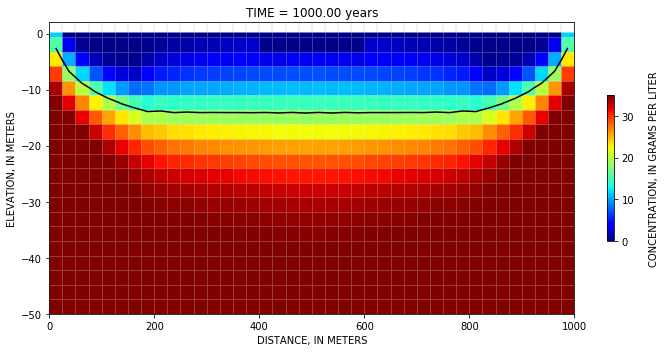

In [50]:
kper = -1
conctoplot = np.where(conc0[kper] > 1e20, lakconc0[kper, 0, 0, 0], conc0[kper])
headtoplot = np.where(head0[kper] > 1e20, stage0[kper, 0, 0, 0], stage0[kper])
ax = make_figure(gwf, headtoplot, conctoplot, spdis0[kper], 
                 times0[kper], top0, streamplot=False)

In [53]:
make_png = True
if make_png:

    pngdir = os.path.join(ws0, 'png')
    if os.path.isdir(pngdir):
        shutil.rmtree(pngdir)
    if not os.path.isdir(pngdir):
        os.mkdir(pngdir)

    kperlist = range(0, conc0.shape[0], 100)
    #kperlist = [0]
    for ifig, kper in enumerate(kperlist):
        fname = 'img{}.png'.format(ifig)
        fname = os.path.join(pngdir, fname)
        print('writing {}'.format(fname))

        conctoplot = np.where(conc0[kper] > 1e20, lakconc0[kper, 0, 0, 0], conc0[kper])
        headtoplot = np.where(head0[kper] > 1e20, stage0[kper, 0, 0, 0], stage0[kper])
        make_figure(gwf, headtoplot, conctoplot, spdis0[kper], 
                    times0[kper], top0,
                    streamplot=False, figname=fname)
        
    # Use ffmpeg to make an animation
    figfile = os.path.join(pngdir, 'img%d.png')
    anmfile = os.path.join(ws0, 'movie.mp4')
    make_movie(figfile, anmfile)

writing temp/pxx_gwt_lakslr/png/img0.png
writing temp/pxx_gwt_lakslr/png/img1.png
writing temp/pxx_gwt_lakslr/png/img2.png
writing temp/pxx_gwt_lakslr/png/img3.png
writing temp/pxx_gwt_lakslr/png/img4.png
writing temp/pxx_gwt_lakslr/png/img5.png
writing temp/pxx_gwt_lakslr/png/img6.png
writing temp/pxx_gwt_lakslr/png/img7.png
writing temp/pxx_gwt_lakslr/png/img8.png
writing temp/pxx_gwt_lakslr/png/img9.png
writing temp/pxx_gwt_lakslr/png/img10.png
writing temp/pxx_gwt_lakslr/png/img11.png
writing temp/pxx_gwt_lakslr/png/img12.png
writing temp/pxx_gwt_lakslr/png/img13.png
writing temp/pxx_gwt_lakslr/png/img14.png
writing temp/pxx_gwt_lakslr/png/img15.png
writing temp/pxx_gwt_lakslr/png/img16.png
writing temp/pxx_gwt_lakslr/png/img17.png
writing temp/pxx_gwt_lakslr/png/img18.png
writing temp/pxx_gwt_lakslr/png/img19.png
writing temp/pxx_gwt_lakslr/png/img20.png
writing temp/pxx_gwt_lakslr/png/img21.png
writing temp/pxx_gwt_lakslr/png/img22.png
writing temp/pxx_gwt_lakslr/png/img23.png
wr

In [18]:
idomain.shape

(40, 100)

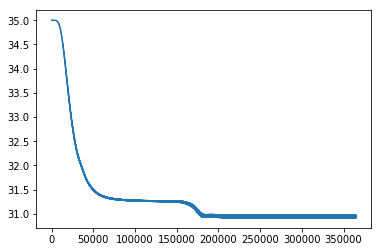

In [19]:
plt.plot(times0, conc0[:, int(nlay/2), 0, int(ncol/2)])

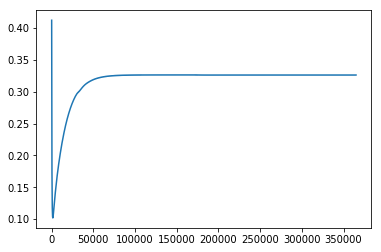

In [20]:
plt.plot(times0, stage0[:, 0, 0, 0])

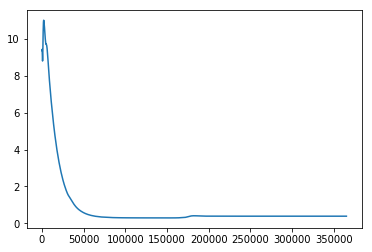

In [21]:
plt.plot(times0, lakconc0[:, 0, 0, 0])

# Model Run with SLR

In [40]:
time_end = 100 * 365.
nper = 100 * 5
ws = 'temp/pxx_gwt_lakslr1'
name = 'lakslr1'
sim = get_model(ws, name, nlay, nrow, ncol, lx,
                 top0, bottom, 
                 time_end, 
                 hk, vk, specific_storage, porosity, 
                 recharge,
                 alpha_l, alpha_t,
                 cfresh, csalt,
                 hlak=stage0[-1, 0, 0, 0],
                 clak=lakconc0[-1, 0, 0, 0],
                 sl_start=0., slr_rate=1./(365. * 100),
                 nper=nper, cstrt=conc0[-1],
                 verbosity_level=1,
                 converge_continue=True)
sim.write_simulation()
v = sim.run_simulation(report=True)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing ims package ims_0...
  writing package lakslr1.gwfgwt...
  writing model gwf_lakslr1...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package buy...
    writing package ghb-0...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 40 based on size of stress_period_data
    writing package rcha...
    writing package lak0...
    writing package oc...
  writing model gwt_lakslr1...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package adv...
    writing package mst...
    writing package ssm...
    writing package lak0...
    writing package oc...
FloPy is using the following  executable to run the model: /Users/langevin/langevin/dev/modflow6-fork.git/bin/mf6
                                

 Solving:  Stress period:   122    Time step:     1
 Solving:  Stress period:   123    Time step:     1
 Solving:  Stress period:   124    Time step:     1
 Solving:  Stress period:   125    Time step:     1
 Solving:  Stress period:   126    Time step:     1
 Solving:  Stress period:   127    Time step:     1
 Solving:  Stress period:   128    Time step:     1
 Solving:  Stress period:   129    Time step:     1
 Solving:  Stress period:   130    Time step:     1
 Solving:  Stress period:   131    Time step:     1
 Solving:  Stress period:   132    Time step:     1
 Solving:  Stress period:   133    Time step:     1
 Solving:  Stress period:   134    Time step:     1
 Solving:  Stress period:   135    Time step:     1
 Solving:  Stress period:   136    Time step:     1
 Solving:  Stress period:   137    Time step:     1
 Solving:  Stress period:   138    Time step:     1
 Solving:  Stress period:   139    Time step:     1
 Solving:  Stress period:   140    Time step:     1
 Solving:  S

 Solving:  Stress period:   281    Time step:     1
 Solving:  Stress period:   282    Time step:     1
 Solving:  Stress period:   283    Time step:     1
 Solving:  Stress period:   284    Time step:     1
 Solving:  Stress period:   285    Time step:     1
 Solving:  Stress period:   286    Time step:     1
 Solving:  Stress period:   287    Time step:     1
 Solving:  Stress period:   288    Time step:     1
 Solving:  Stress period:   289    Time step:     1
 Solving:  Stress period:   290    Time step:     1
 Solving:  Stress period:   291    Time step:     1
 Solving:  Stress period:   292    Time step:     1
 Solving:  Stress period:   293    Time step:     1
 Solving:  Stress period:   294    Time step:     1
 Solving:  Stress period:   295    Time step:     1
 Solving:  Stress period:   296    Time step:     1
 Solving:  Stress period:   297    Time step:     1
 Solving:  Stress period:   298    Time step:     1
 Solving:  Stress period:   299    Time step:     1
 Solving:  S

 Solving:  Stress period:   440    Time step:     1
 Solving:  Stress period:   441    Time step:     1
 Solving:  Stress period:   442    Time step:     1
 Solving:  Stress period:   443    Time step:     1
 Solving:  Stress period:   444    Time step:     1
 Solving:  Stress period:   445    Time step:     1
 Solving:  Stress period:   446    Time step:     1
 Solving:  Stress period:   447    Time step:     1
 Solving:  Stress period:   448    Time step:     1
 Solving:  Stress period:   449    Time step:     1
 Solving:  Stress period:   450    Time step:     1
 Solving:  Stress period:   451    Time step:     1
 Solving:  Stress period:   452    Time step:     1
 Solving:  Stress period:   453    Time step:     1
 Solving:  Stress period:   454    Time step:     1
 Solving:  Stress period:   455    Time step:     1
 Solving:  Stress period:   456    Time step:     1
 Solving:  Stress period:   457    Time step:     1
 Solving:  Stress period:   458    Time step:     1
 Solving:  S

In [41]:
# load results
head, conc, spdis, stage, lakconc, times = get_results(ws, sim)
gwf = sim0.get_model('gwf_lakslr')

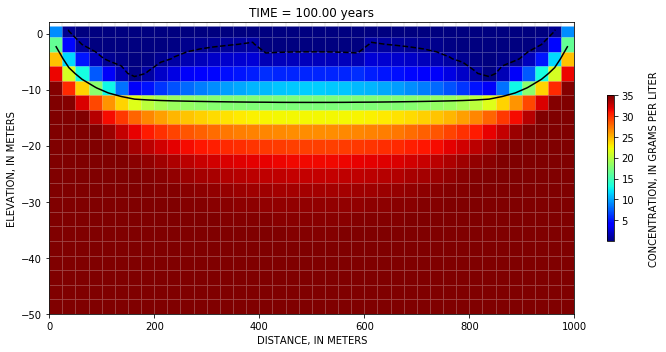

In [89]:
kper = -1
conctoplot = np.where(conc[kper] > 1e20, lakconc[kper, 0, 0, 0], conc[kper])
headtoplot = np.where(head[kper] > 1e20, stage[kper, 0, 0, 0], stage[kper])
#conctoplot = np.ma.masked_greater(conc[kper], 1e20)
ax = make_figure(gwf, headtoplot, conctoplot, spdis[kper], 
                 times[kper], top0, streamplot=False)

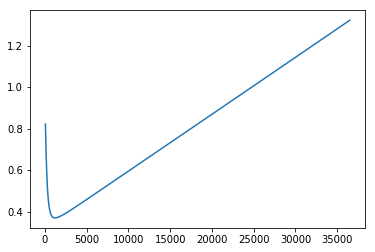

In [43]:
plt.plot(times, stage[:, 0, 0, 0])

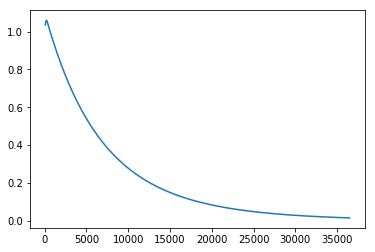

In [44]:
plt.plot(times, lakconc[:, 0, 0, 0])

/Users/langevin/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


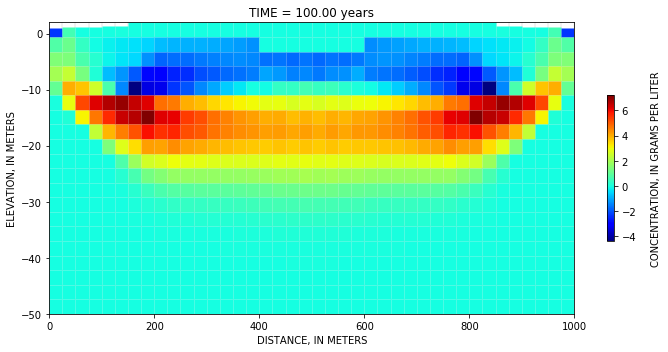

In [45]:
conctoplot = np.ma.masked_greater(conc[-1] - conc0[-1], 1e20)
ax = make_figure(gwf, head[kper], conctoplot, spdis[kper], 
                 times[kper], top0, streamplot=False)

In [49]:
make_png = True
if make_png:

    pngdir = os.path.join(ws, 'png')
    if os.path.isdir(pngdir):
        shutil.rmtree(pngdir)
    if not os.path.isdir(pngdir):
        os.mkdir(pngdir)

    kperlist = range(0, conc.shape[0], 10)
    #kperlist = [0]
    for ifig, kper in enumerate(kperlist):
        fname = 'img{}.png'.format(ifig)
        fname = os.path.join(pngdir, fname)
        print('writing {}'.format(fname))

        conctoplot = np.where(conc[kper] > 1e20, lakconc[kper, 0, 0, 0], conc[kper])
        headtoplot = np.where(head[kper] > 1e20, stage[kper, 0, 0, 0], stage[kper])
        make_figure(gwf, headtoplot, conctoplot, spdis0[kper], 
                    times[kper], top0,
                    streamplot=False, figname=fname)
        
    # Use ffmpeg to make an animation
    figfile = os.path.join(pngdir, 'img%d.png')
    anmfile = os.path.join(ws, 'movie.mp4')
    make_movie(figfile, anmfile)

writing temp/pxx_gwt_lakslr1/png/img0.png
writing temp/pxx_gwt_lakslr1/png/img1.png
writing temp/pxx_gwt_lakslr1/png/img2.png
writing temp/pxx_gwt_lakslr1/png/img3.png
writing temp/pxx_gwt_lakslr1/png/img4.png
writing temp/pxx_gwt_lakslr1/png/img5.png
writing temp/pxx_gwt_lakslr1/png/img6.png
writing temp/pxx_gwt_lakslr1/png/img7.png
writing temp/pxx_gwt_lakslr1/png/img8.png
writing temp/pxx_gwt_lakslr1/png/img9.png
writing temp/pxx_gwt_lakslr1/png/img10.png
writing temp/pxx_gwt_lakslr1/png/img11.png
writing temp/pxx_gwt_lakslr1/png/img12.png
writing temp/pxx_gwt_lakslr1/png/img13.png
writing temp/pxx_gwt_lakslr1/png/img14.png
writing temp/pxx_gwt_lakslr1/png/img15.png
writing temp/pxx_gwt_lakslr1/png/img16.png
writing temp/pxx_gwt_lakslr1/png/img17.png
writing temp/pxx_gwt_lakslr1/png/img18.png
writing temp/pxx_gwt_lakslr1/png/img19.png
writing temp/pxx_gwt_lakslr1/png/img20.png
writing temp/pxx_gwt_lakslr1/png/img21.png
writing temp/pxx_gwt_lakslr1/png/img22.png
writing temp/pxx_gwt_

In [54]:
conc.shape

(500, 20, 1, 40)

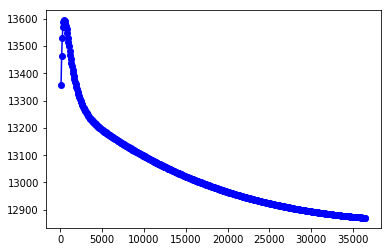

In [81]:
delr = lx / ncol
delv = (top0 - bottom) / nlay
top = gwf.dis.top.array
botm = gwf.dis.botm.array
vlenslist = []
for kper in range(conc.shape[0]):
    c = np.where(conc[kper] > 1e20, lakconc[kper, 0, 0, 0], conc[kper])
    hd = np.where(head[kper] > 1e20, stage[kper, 0, 0, 0], head[kper])
    nlay, nrow, ncol = c.shape
    vlens = 0.
    for k in range(nlay):
        for j in range(ncol):
            f = (1. - c[k, 0, j] / csalt)                
            h = hd[k, 0, j]
            if k == 0:
                ht = top[0, j]
            else:
                ht = botm[k - 1, 0, j]
            ht = max(min(h, ht), botm[k, 0, j])
            delv = (ht - botm[k, 0, j])
            vlens += f * delr * delv 
    vlenslist.append(vlens)
plt.plot(times, vlenslist, 'bo-')

In [83]:
slp = (vlenslist[-1] - vlenslist[0]) / 100.
print(slp)

-4.883643267557363


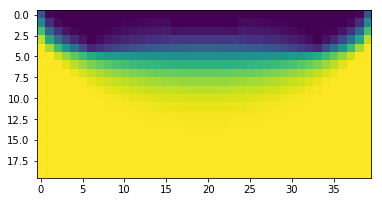

In [85]:
plt.imshow(c[:, 0, :])